In [7]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from collections import Counter
import random
from sklearn.preprocessing import StandardScaler

# Long-Short term memory 

## Load data

In [8]:
breaking = np.load("extracted_data/breaking.npy")
steering =  np.load("extracted_data/steering.npy")
acceleration = np.load("extracted_data/acceleration.npy")
normal = np.load("extracted_data/normal.npy")

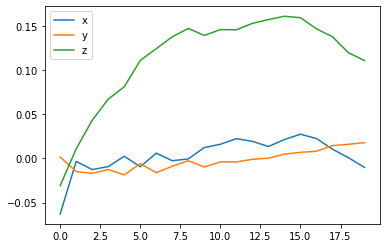

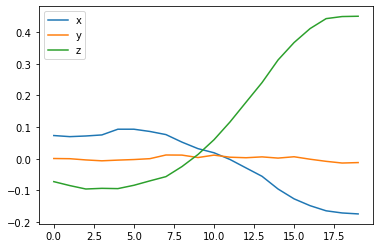

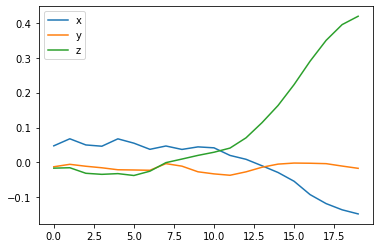

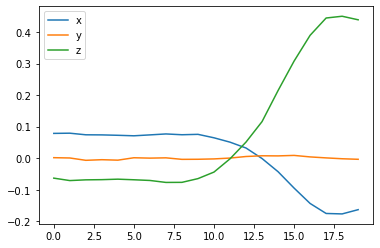

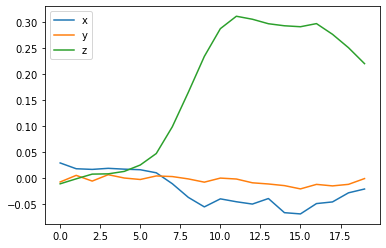

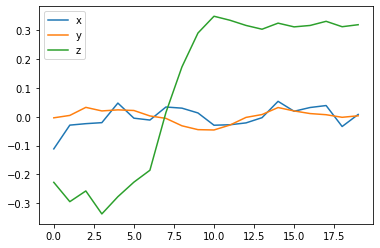

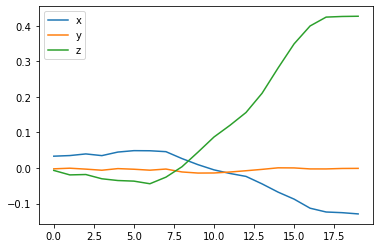

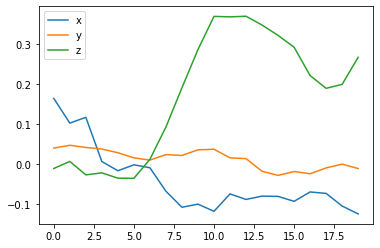

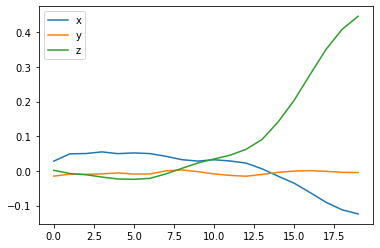

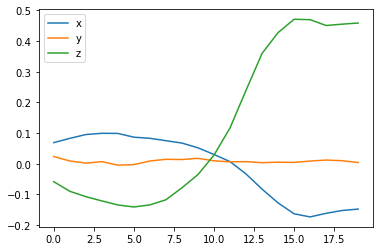

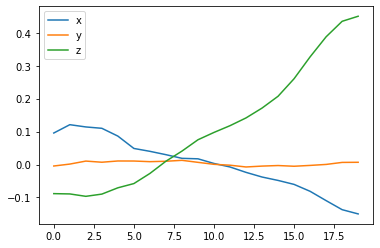

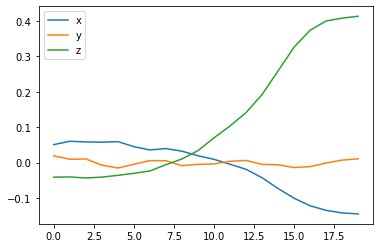

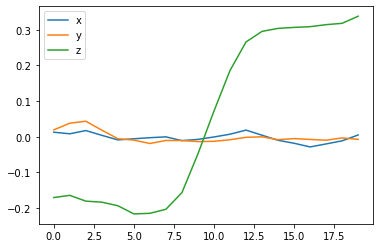

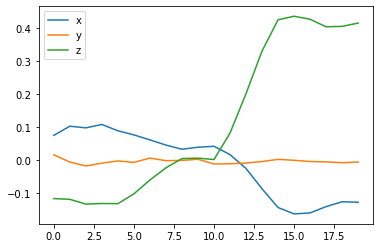

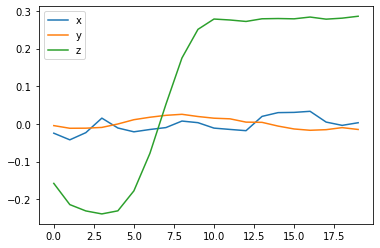

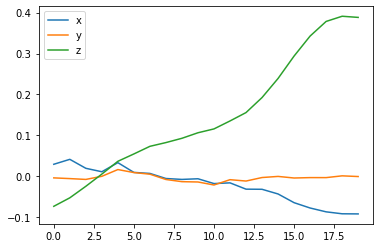

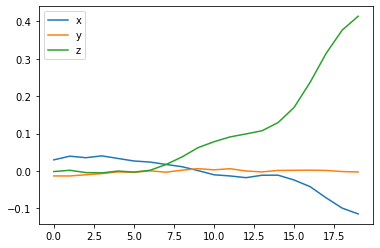

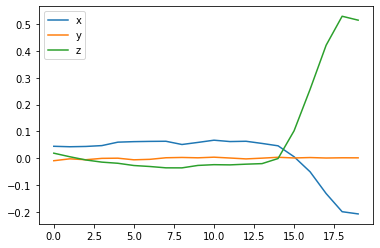

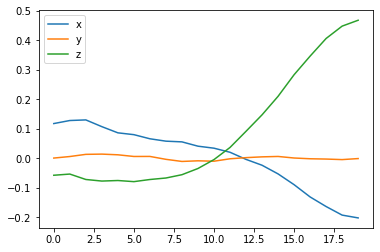

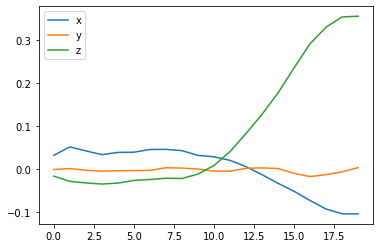

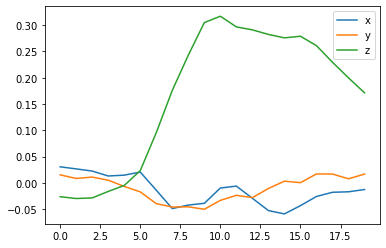

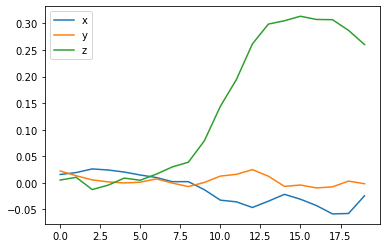

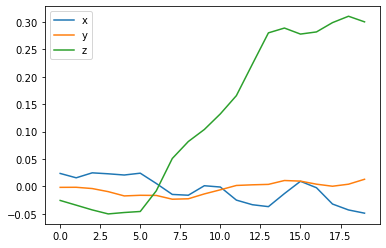

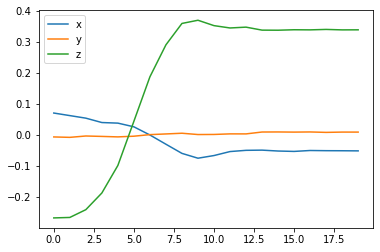

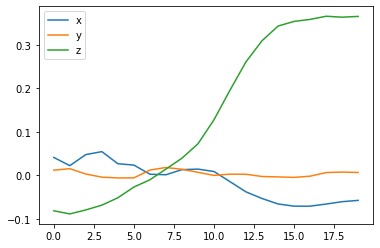

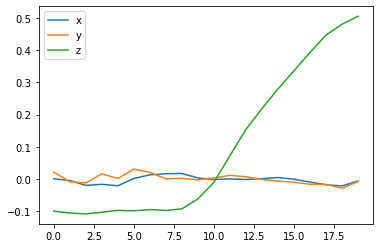

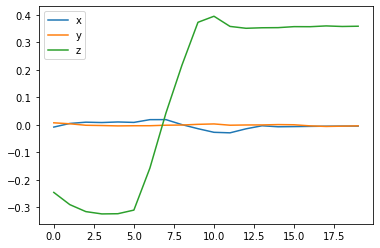

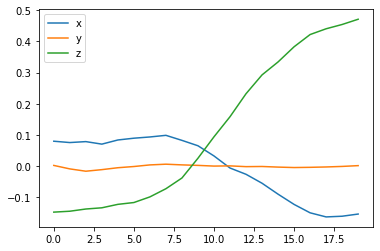

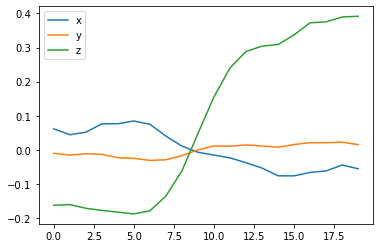

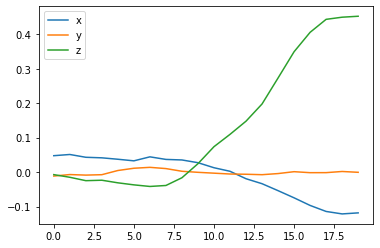

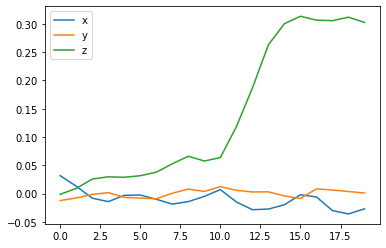

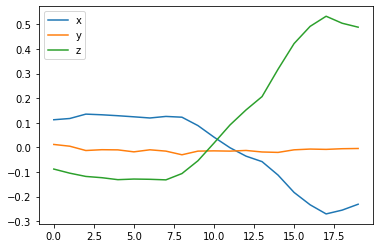

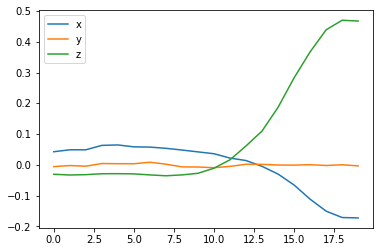

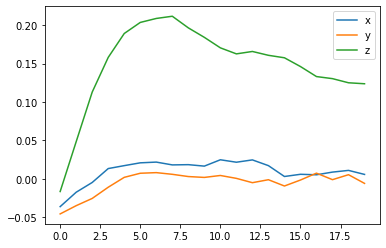

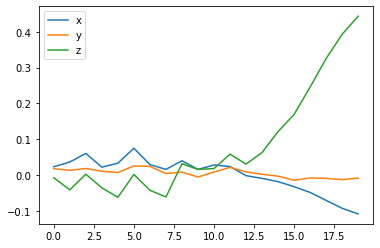

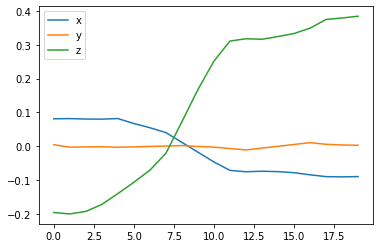

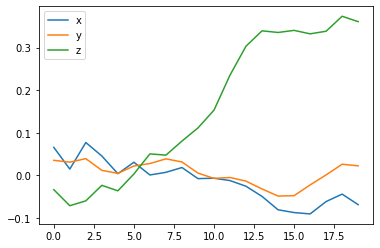

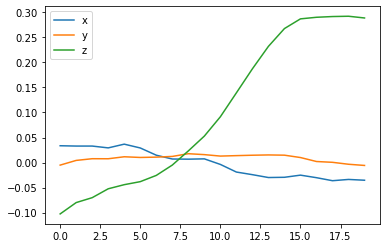

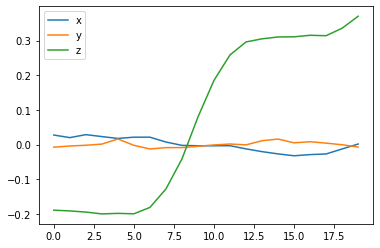

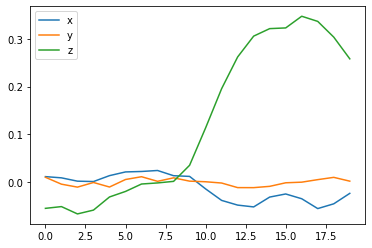

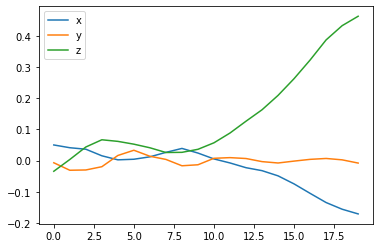

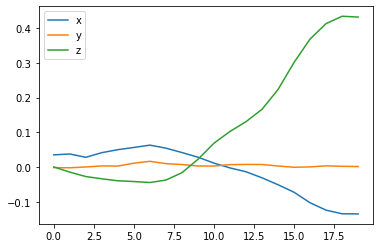

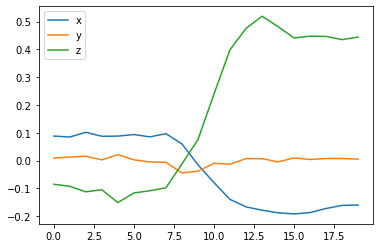

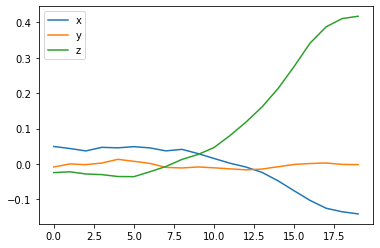

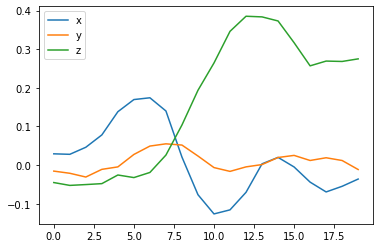

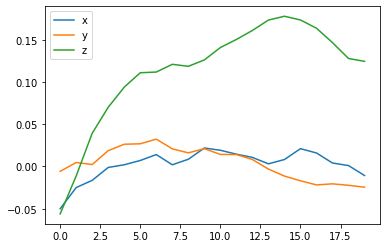

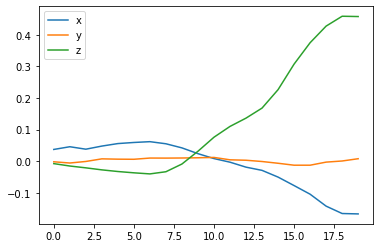

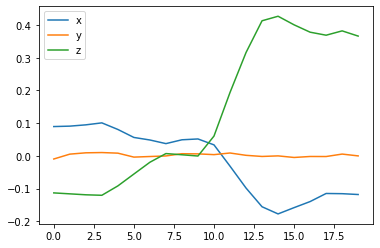

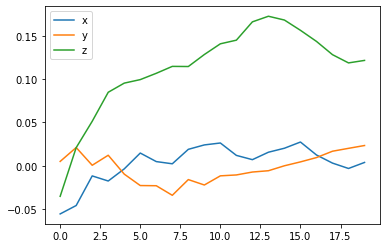

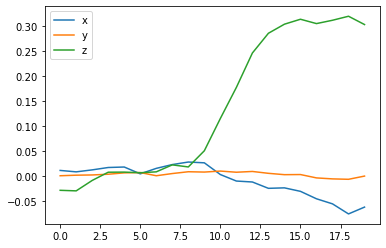

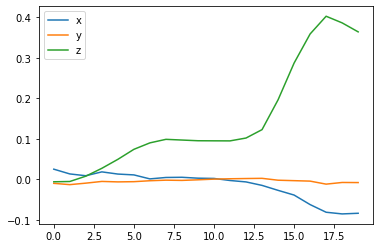

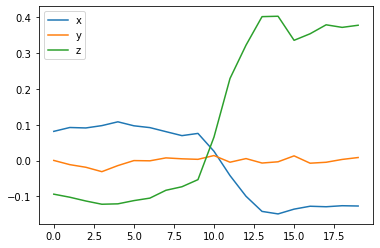

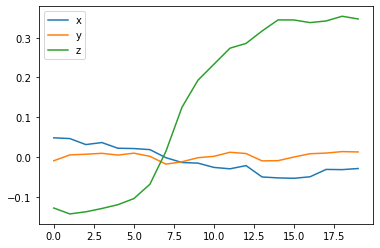

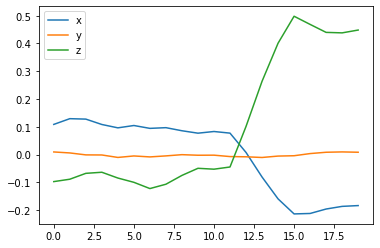

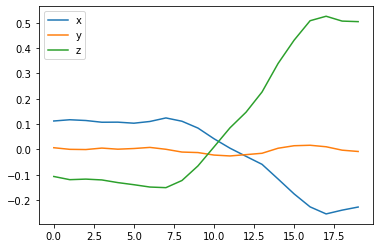

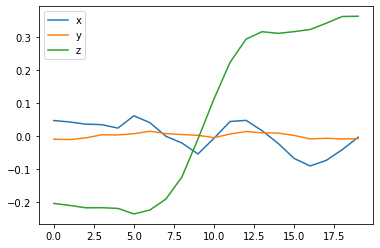

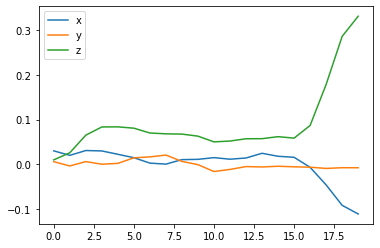

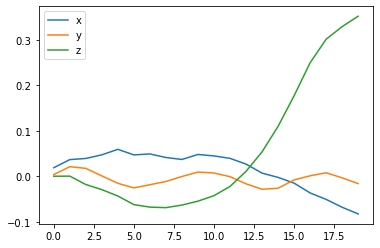

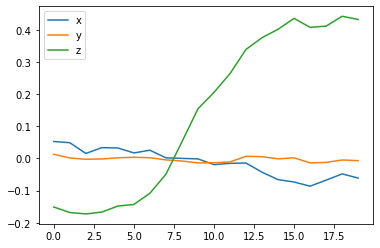

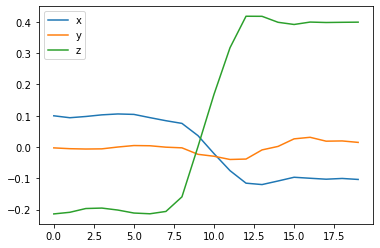

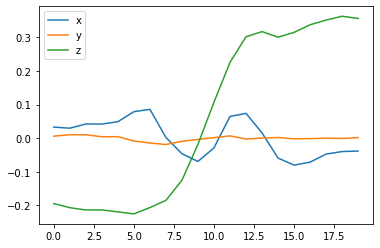

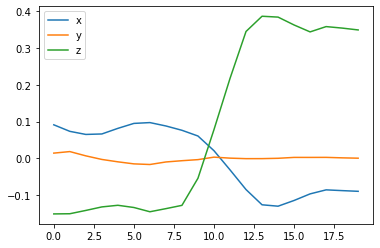

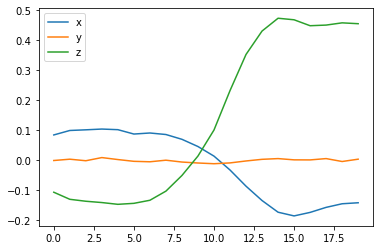

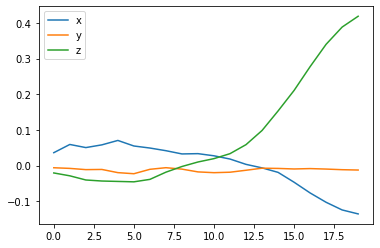

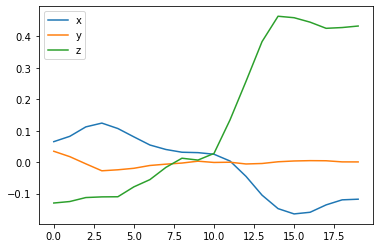

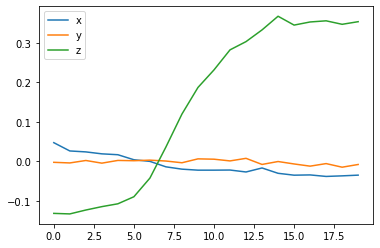

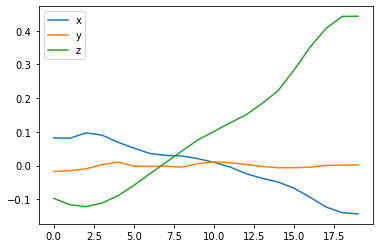

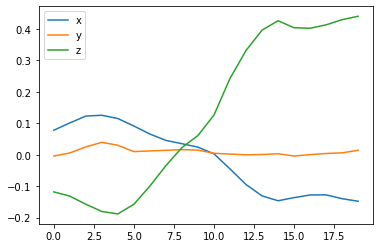

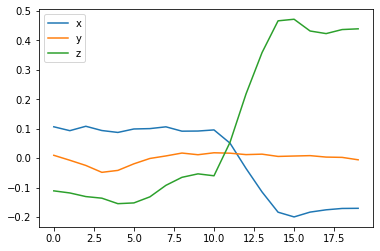

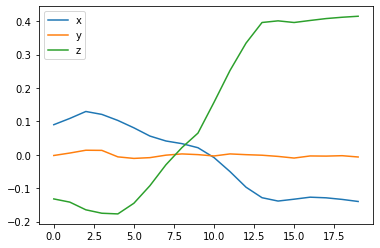

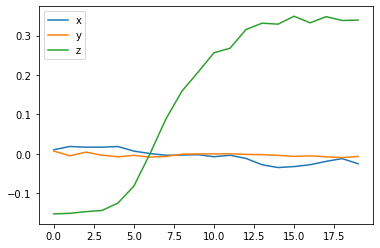

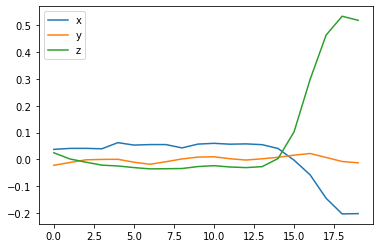

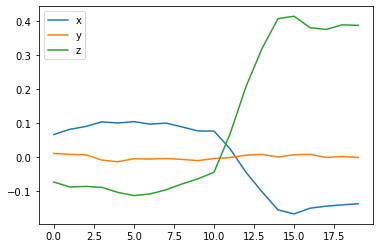

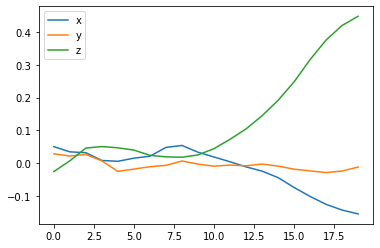

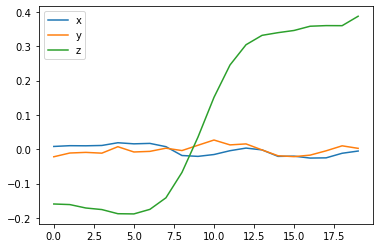

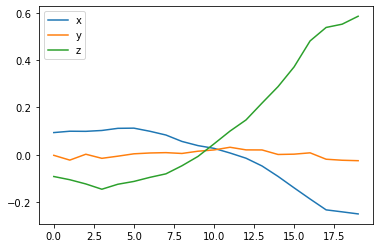

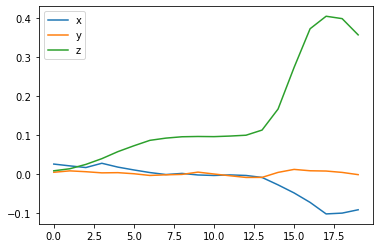

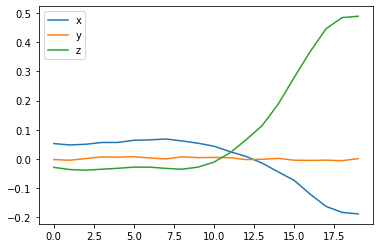

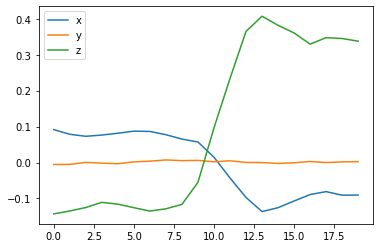

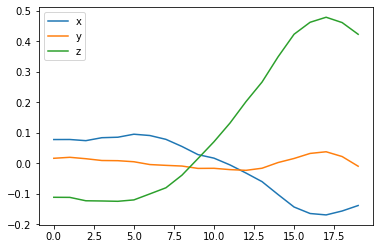

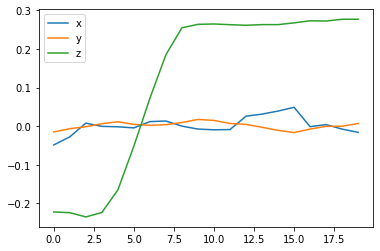

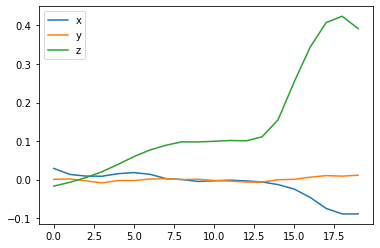

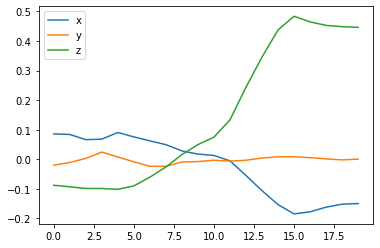

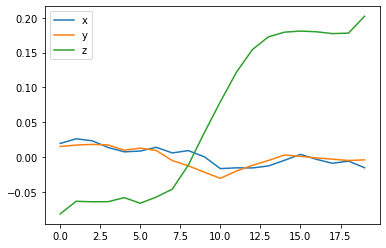

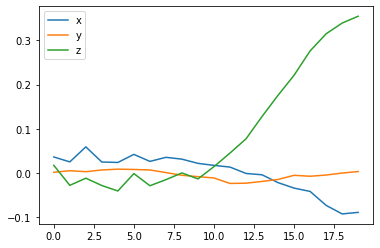

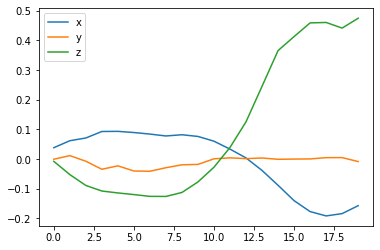

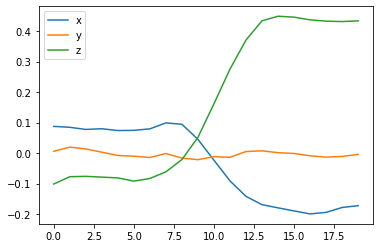

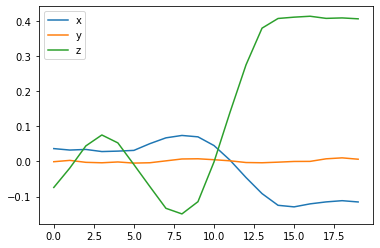

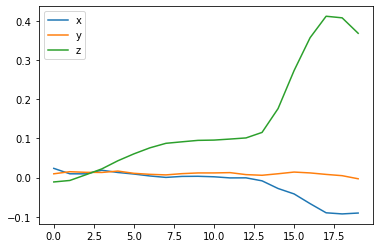

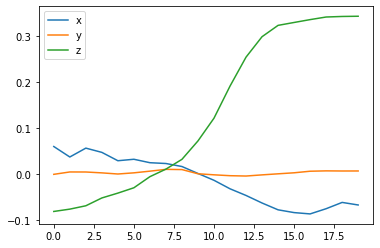

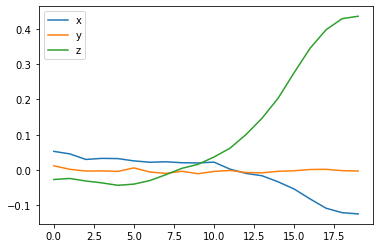

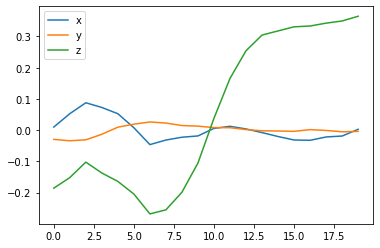

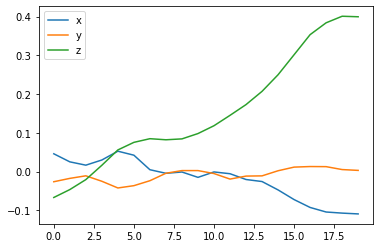

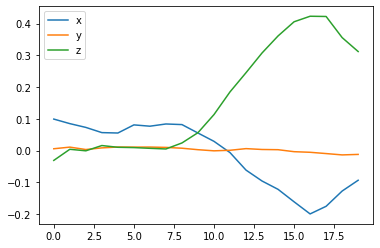

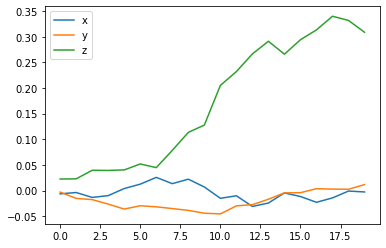

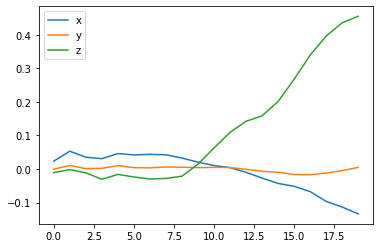

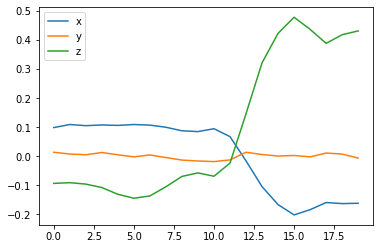

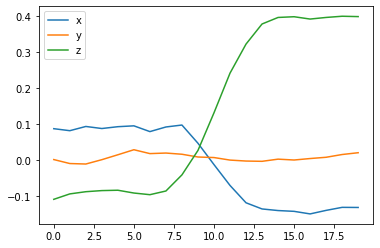

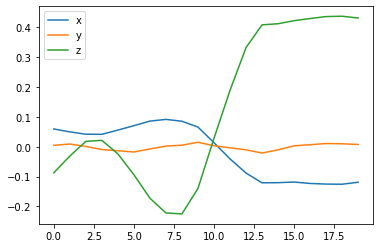

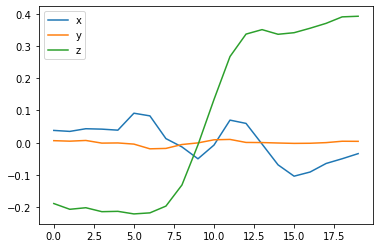

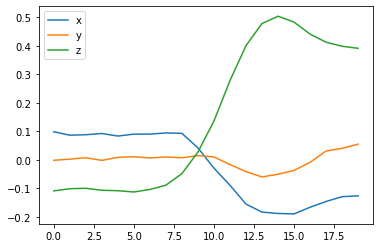

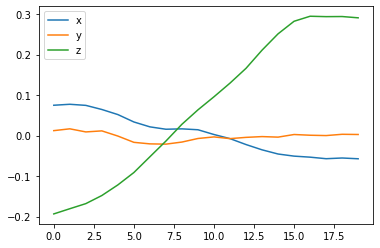

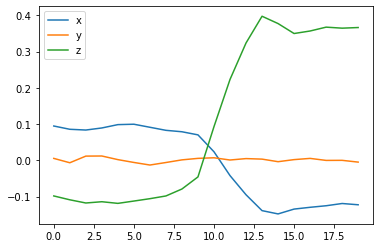

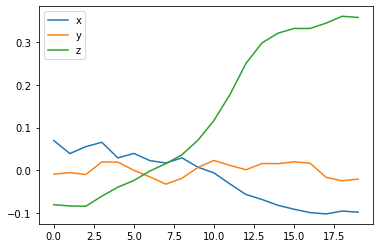

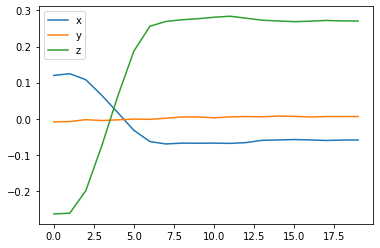

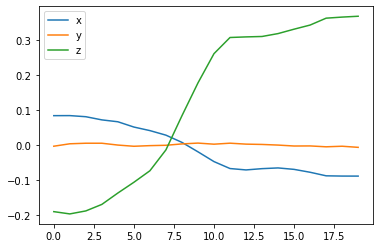

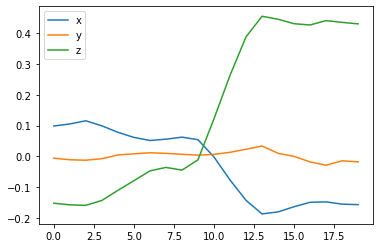

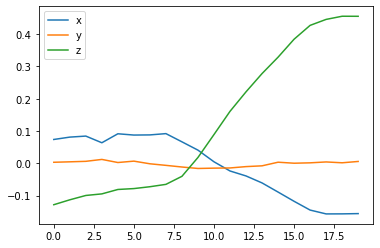

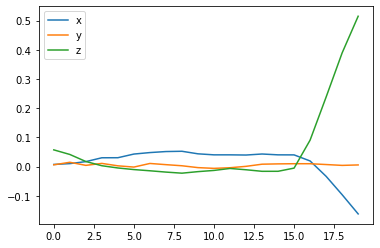

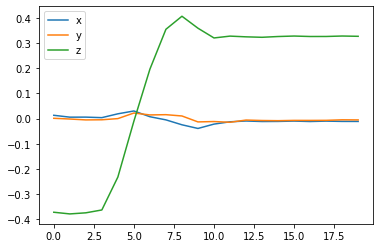

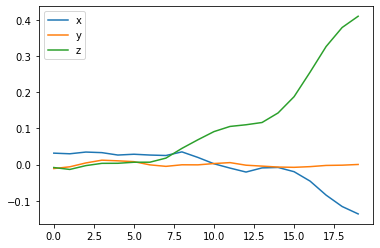

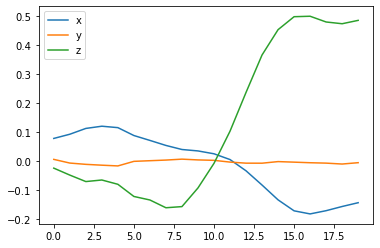

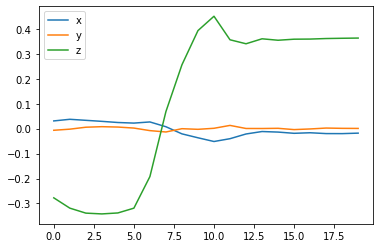

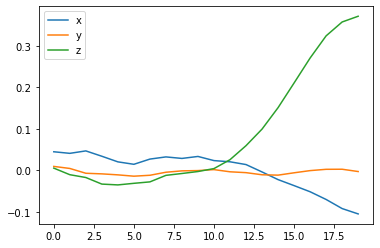

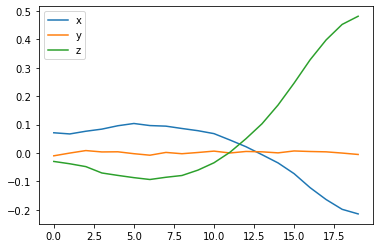

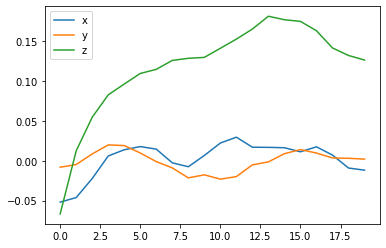

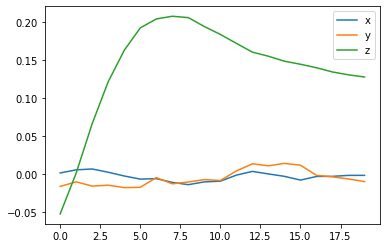

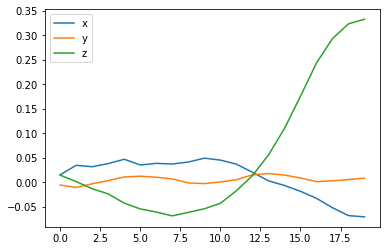

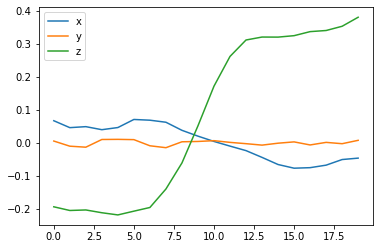

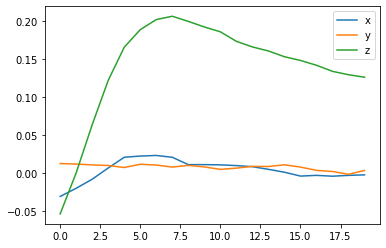

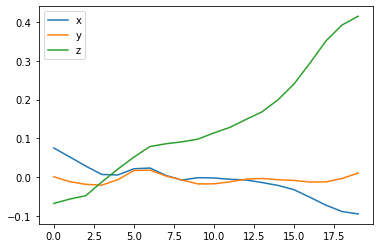

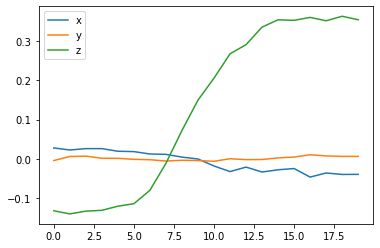

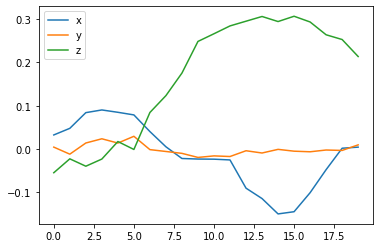

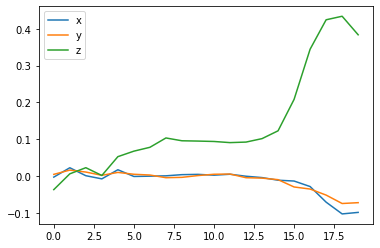

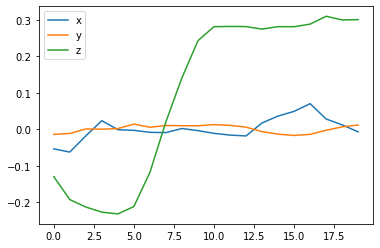

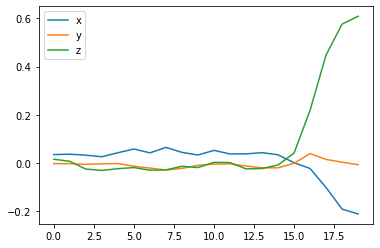

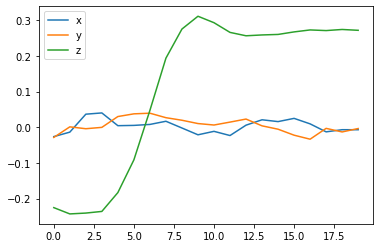

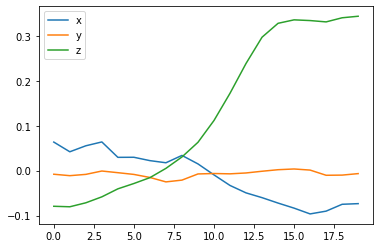

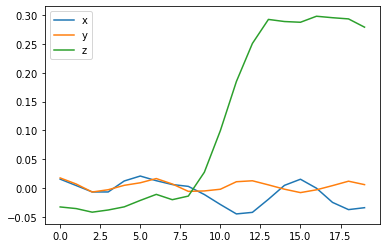

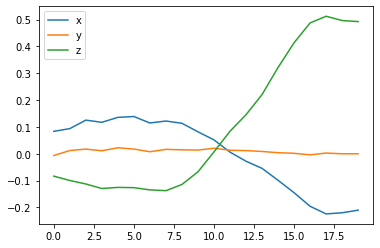

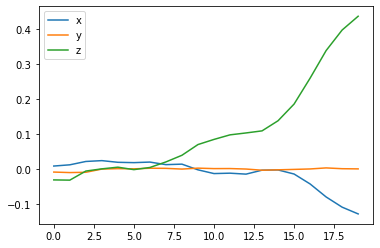

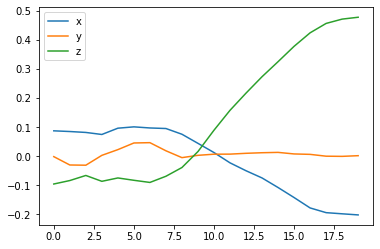

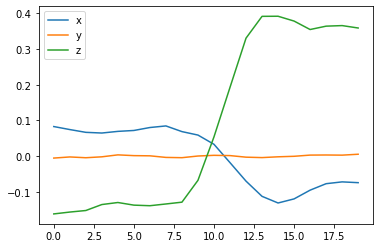

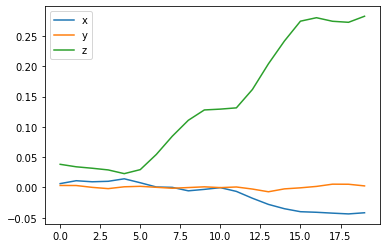

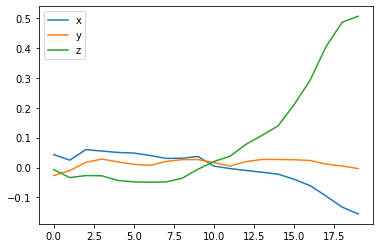

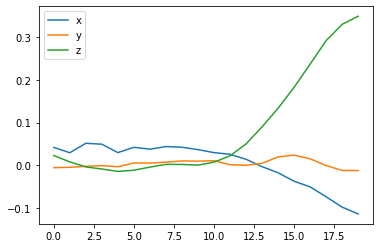

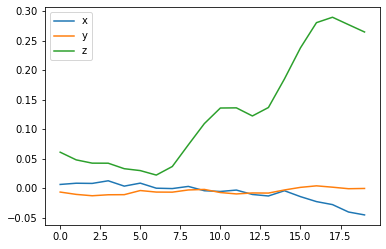

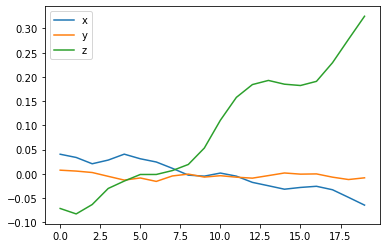

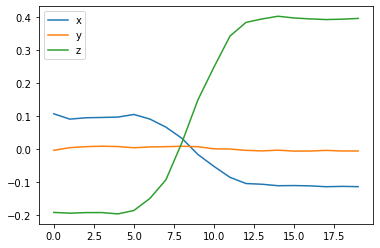

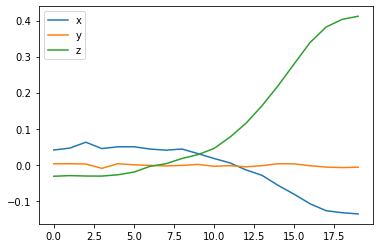

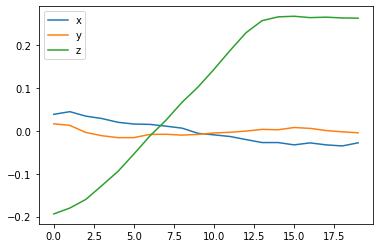

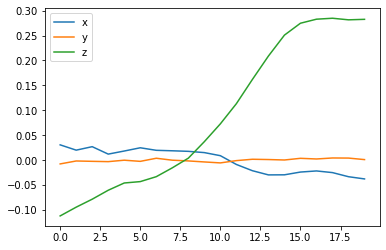

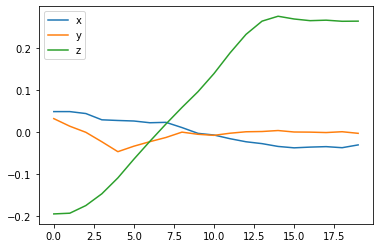

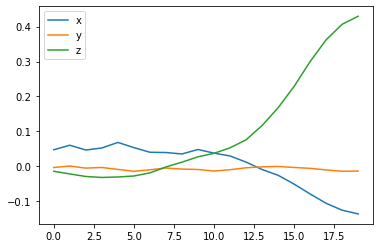

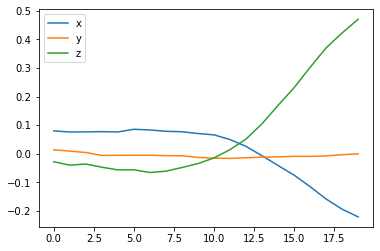

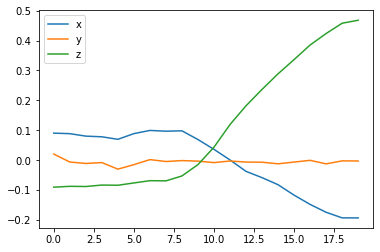

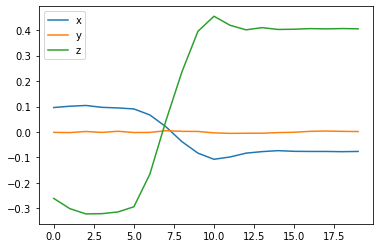

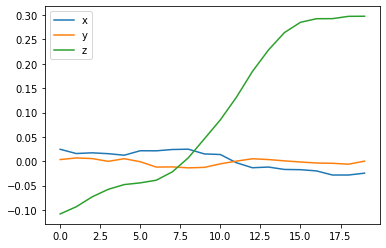

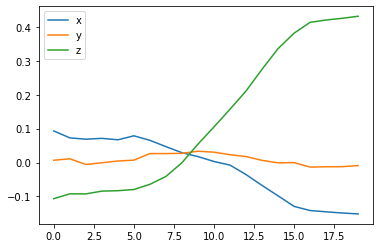

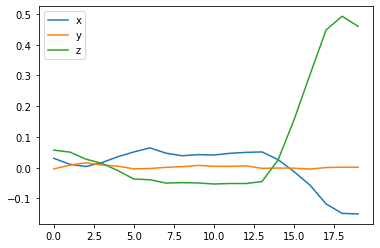

In [4]:
import matplotlib.pyplot as plt
for i in breaking:
    x,y,z = i[:,0],i[:,1],i[:,2]
    plt.plot(x, label="x")
    plt.plot(y, label="y")
    plt.plot(z, label="z")
    plt.legend()
    plt.show()

## Build and evaluate model

In [9]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
def split_data (b ,s ,a, n):
    ## split data
    X_train_break, X_test_break, y_train_break, y_test_break = train_test_split(b, np.array([0]*150), test_size=0.3, random_state=42)
    X_train_steer, X_test_steer, y_train_steer, y_test_steer = train_test_split(s, np.array([1]*150), test_size=0.3, random_state=42)
    X_train_acc, X_test_acc, y_train_acc, y_test_acc = train_test_split(a, np.array([2]*150), test_size=0.3, random_state=42)
    X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(n, np.array([3]*148), test_size=0.3, random_state=42)
    ## combine data 
    X_combined_train = np.concatenate((X_train_break ,X_train_steer ,X_train_acc, X_train_norm), axis=0)
    Y_combined_train = np.concatenate((y_train_break ,y_train_steer ,y_train_acc, y_train_norm), axis=0)
    X_combined_test = np.concatenate((X_test_break ,X_test_steer ,X_test_acc, X_test_norm), axis=0)
    Y_combined_test = np.concatenate((y_test_break ,y_test_steer ,y_test_acc, y_test_norm), axis=0)
    ## shuffle data
    X_train, y_train = shuffle(X_combined_train, Y_combined_train)
    X_test,  y_test= shuffle(X_combined_test, Y_combined_test)
    
    return (X_train, X_test, y_train, y_test)
    

In [10]:
def reshape (data):
    return data.reshape(data.shape[0], data.shape[1], data.shape[2], 1)

In [22]:
from keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

def lstm_model (rows,columns):
    model = Sequential()
    model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(rows,columns)))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=True))
    model.add(LSTM(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [42]:
from sklearn.metrics import accuracy_score
def evaluate (b ,s ,a, n):
    evaluation_results = dict()
    
    for i in range(5):
        results = dict()
        X_train, X_test, y_train, y_test = split_data (b ,s ,a, n)
      
        ## model
        model = lstm_model (20,3)
        history = model.fit(X_train, y_train, epochs = 100, validation_split=0.2, verbose=0)

        ## evaluate
        predict = model.predict(X_test)
        classes = np.rint(predict).ravel()
        temp = list()
        for e in classes:
            if e > 3:temp.append(3)
            elif e < 0:temp.append(0)
            else: temp.append(e)
        classes = np.array(temp)
        mat = confusion_matrix(y_test, classes)
        results["mat"] = mat
        results["score"] = accuracy_score(y_test, classes)

        evaluation_results[i] = results
        
    return evaluation_results,model 


In [43]:
logs,model = evaluate(breaking ,steering ,acceleration, normal)

Accuracy: 0.9588888888888889


(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

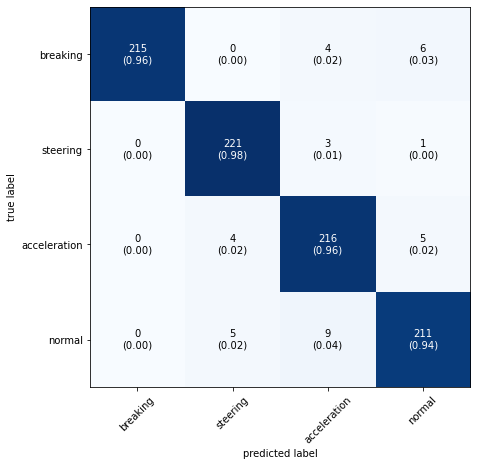

In [44]:
mat = np.zeros((4,4))
accuracy = 0
for key,value in logs.items():
    mat +=  logs[key]["mat"]
    accuracy += logs[key]["score"]
    
    
print("Accuracy:",accuracy/5)
    
plot_confusion_matrix(conf_mat=mat.astype(int), class_names=["breaking", "steering","acceleration", "normal"], show_normed=True, figsize=(7,7))